# don't forget to hop into the conda3 virtual environment — source activate base

To Dos:
<ul>
    <li> load glucose + fasting status</li>
    <li> make sure to add smoking to the risk factor models</li>
    <li> physical activity...is ther ea quesiton that aligns with "have you exercisedin the last two weeks?</li>
    <li> waist circumference</li>
    <li> creatinine/GFR</li>
    <li> a. fib </li>
    <li> build out the nhanes file loader method below into something prettier</li>
</ul>

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', None)

### Function to download NHANES files for specific variables

In [6]:
import wget
baseDir = "/Users/burke/Documents/research/bpCog/nhanes/sourceData/"
os.chdir(baseDir)

fileStems = ['LAB10AM', 'L10_2_B','L10AM_C', 'GLU_D', 'GLU_E', 'GLU_F', 'GLU_G', 'GLU_H', 'GLU_I' ]

stemIndex = 0    
for year in range(1999,2016,2):
    plusOne = year + 1
    os.chdir("nhanesRawData/" + str(year) + "-" + str(plusOne))
    url = "https://wwwn.cdc.gov/Nchs/Nhanes/" + str(year) + "-" + str(plusOne) + "/" + fileStems[stemIndex] + ".XPT"
    print(url)
    wget.download(url)
        
    os.chdir(baseDir)
    stemIndex += 1

https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/LAB10AM.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2001-2002/L10_2_B.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/L10AM_C.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/GLU_D.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/GLU_E.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/GLU_F.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/GLU_G.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/GLU_H.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/GLU_I.XPT


### Load All NHANES Data Files and append into a single dataset



In [7]:
''' iterate through the root directory which has subdiretxories (with year names) for each annual collection of 
raw NHANES data files '''

root = next(os.walk("nhanesRawData"))[0]
yearDirs = next(os.walk("nhanesRawData"))[1]
yearDirsWithRoot = [root + os.sep + year for year in yearDirs]

# loads the files from a year — starts with the demographics files and then merges in all of the other subfiles in the directory

def loadYear(dir):
    demographics = getDemographics(dir)
    otherFiles = next(os.walk(dir))[2]
    otherFiles.remove(demographics)
    
    demoSAS = pd.read_sas(dir + os.sep + demographics)
    for other in otherFiles:
        otherSAS = pd.read_sas(dir + os.sep + other)
        demoSAS = demoSAS.merge(otherSAS, how='left', on=['SEQN'])
    year = dir[dir.find(os.sep)+1:dir.find("-")]
    demoSAS['year'] = year
    
    columnNameMappings = {"RIDAGEYR" : "age", "RIAGENDR" :  "gender",  "RIDRETH1" : "raceEthnicity",
                      "BPXSY1" : "sbp1", "BPXSY2" : "sbp2", "BPXSY3" : "sbp3", "BPXSY4" : "sbp4", "BPXDI1" : "dbp1",
                     "BPXDI2": "dbp2", "BPXDI3" : "dbp3", "BPXDI4" : "dbp4", "LBXGH" : "a1c", "LBDHDD" : "hdl",
                     "LBXTC" : "tot_chol", "SMQ040" : "currentSmoker", "SMQ020" : "quantitySmoked","BMXWT" : "weight",
                      "BMXBMI" : "bmi", "LBDLDL" : "ldl", "LBDTRSI" : "trig",  
                      "DMDYRSUS" : "timeInUS", "MORTSTAT" : "diedBy2011"}
    
    alternateNames = {'LBXTC' : ['LBXTC_x' ], 'LBDHDD' : ['LBDHDL','LBXHDD', 'LBDHDL_x']}
    
    print (year)
    demoSAS.to_csv(str(year + "Before.csv"))
    # we have a couple variable names that get remapped to differnet names...this will remap them all to consistent names
    for key in alternateNames.keys():
        if key not in demoSAS:
            print(str(key) + " is missing from year: " + str(year))
            for value in alternateNames[key]:
                print ("checking: " + value)
                if value in demoSAS:
                    print ("rename: " + value + " to key: " + key)
                    demoSAS.rename(columns={value: key}, inplace=True)

    demoSAS.to_csv(str(year + "InBetween.csv"))

    
    columnsToKeep = list(columnNameMappings.keys())
    columnsToKeep.extend(["SEQN", "WTINT2YR", "WTMEC2YR", "SDMVPSU", "SDMVSTRA", "year"])
    
    # some of the factors that we car eabout are missing in given years...add them and make them null here.
    for value in columnsToKeep:
        if value not in demoSAS:
            demoSAS[value] = np.nan
    
    demoSAS = demoSAS[columnsToKeep]
    demoSAS.rename(columns=columnNameMappings, inplace=True)
    demoSAS.to_csv(str(year) + ".csv")
    
    return demoSAS

def getDemographics(dir):
    files = next(os.walk(dir))[2]
    for file in files:
        if file.startswith("DEMO"):
            return file
    raise Exception("Unable to find demographics file in directory: " + dir)
    

yearDataFrames = [loadYear(x) for x in yearDirsWithRoot]
combined = pd.concat(yearDataFrames, sort=True)

### Clean up some variables with muitple field names and build a smoking summary variable

over18 = combined.loc[combined.age > 18]

# combine the two smoking status variables into a variable that fits into ASCVD
def generateSmokingStatus(x):
    if np.isclose(x.currentSmoker, 1, 0.0001) or np.isclose(x.currentSmoker, 2, 0.0001):
        return "2"
    elif np.isclose(x.quantitySmoked, 1, 0.0001):
        return "1"
    else:
        return "0"
    
smokingStatusValues = [generateSmokingStatus(x) for _,x in over18.iterrows()]
over18 = over18.assign(smokingStatus=pd.Series(data=smokingStatusValues, index=over18.index, dtype="category"))
over18.drop(labels=["currentSmoker", "quantitySmoked"],axis=1, inplace=True)
over18.raceEthnicity = over18.raceEthnicity.astype('int')
over18.raceEthnicity = over18.raceEthnicity.astype("category")

over18['meanSBP'] = over18[['sbp1', 'sbp2', 'sbp3', 'sbp4']].mean(axis=1)
over18['meanDBP'] = over18[['dbp1', 'dbp2', 'dbp3', 'dbp4']].mean(axis=1)

2011
2015
2007
2003
LBDHDD is missing from year: 2003
checking: LBDHDL
checking: LBXHDD
rename: LBXHDD to key: LBDHDD
checking: LBDHDL_x
2009
2001
LBXTC is missing from year: 2001
checking: LBXTC_x
rename: LBXTC_x to key: LBXTC
LBDHDD is missing from year: 2001
checking: LBDHDL
checking: LBXHDD
checking: LBDHDL_x
rename: LBDHDL_x to key: LBDHDD
2005
1999
LBXTC is missing from year: 1999
checking: LBXTC_x
rename: LBXTC_x to key: LBXTC
LBDHDD is missing from year: 1999
checking: LBDHDL
checking: LBXHDD
checking: LBDHDL_x
rename: LBDHDL_x to key: LBDHDD
2013


### Summarize the missing data — used mostly for data checks


In [9]:

over18.groupby('year').apply(lambda x : x.count()) / len(over18)

regressDF = over18.copy()
#regressDF.drop("year", axis=1, inplace=True)
regressDF = pd.get_dummies(regressDF, columns =['raceEthnicity', 'smokingStatus'])
regressDF.drop(labels=['SEQN', 'WTMEC2YR', 'SDMVPSU','SDMVSTRA' ],axis=1, inplace=True)
regressDF.drop(labels=['sbp1', 'sbp2','sbp3', 'sbp4','dbp1', 'dbp2', 'dbp3', 'dbp4' ],axis=1, inplace=True)
regressDF.year = regressDF.year.astype(int)



In [10]:
regressDF.head()

,WTINT2YR,a1c,age,bmi,diedBy2011,gender,hdl,ldl,timeInUS,tot_chol,trig,weight,year,meanSBP,meanDBP,raceEthnicity_1,raceEthnicity_2,raceEthnicity_3,raceEthnicity_4,raceEthnicity_5,smokingStatus_0,smokingStatus_1,smokingStatus_2
0,102641.406474,5.1,22.0,23.3,NaN,1.0,41.0,110.0,NaN,168.0,0.948,69.2,2011,110.666667,74.666667,0,0,1,0,0,1,0,0
3,127351.373299,4.9,44.0,23.2,NaN,2.0,28.0,151.0,NaN,190.0,0.632,67.2,2011,118.000000,60.000000,0,0,1,0,0,1,0,0
8,14391.778470,5.4,21.0,20.1,NaN,1.0,43.0,73.0,NaN,132.0,0.881,54.6,2011,124.666667,78.000000,0,0,0,0,1,1,0,0
11,26960.774346,5.6,43.0,33.3,NaN,2.0,73.0,68.0,NaN,169.0,1.592,98.6,2011,102.000000,71.333333,0,0,0,1,0,0,0,1
13,24912.668432,5.0,80.0,33.9,NaN,1.0,54.0,NaN,NaN,203.0,NaN,95.8,2011,98.000000,38.000000,0,0,1,0,0,1,0,0


### Use MICE to impute missing data



/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


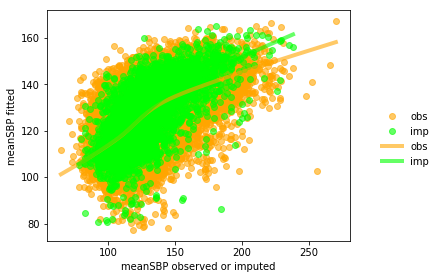

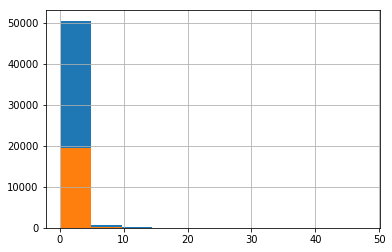

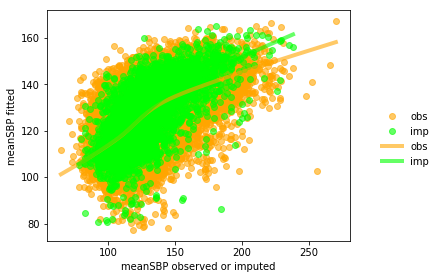

In [11]:

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    fml = fml + ' + year '
    return fml

imputedData = mice.MICEData(regressDF)
# have to leave LDL and trig out of each other's imputations...since their missingness is highly correlated
imputedData.set_imputer("ldl", formula='hdl + tot_chol + age + a1c + bmi + meanSBP + meanDBP + year')
imputedData.set_imputer("trig", formula='hdl + tot_chol + age + a1c + bmi + meanSBP + meanDBP + year')

for var in ['a1c', 'hdl', 'tot_chol', 'weight','bmi','meanSBP', 'meanDBP']:
    imputedData.set_imputer(var, formula=ols_formula(regressDF, var))

imputedData.update_all(20)

### Check missing data in imputed vs. baseline dataset...generally looks pretty good

regressDF.meanSBP.describe()

imputedData.data.meanSBP.describe()

%matplotlib inline
imputedData.data.trig.hist()
regressDF.trig.hist()

imputedData.plot_fit_obs("meanSBP")



### Export imputed dataset


In [12]:
# the imputation reset the time in US variable...we actally want the nulls there because they represent people
# that have been in the US their whole lives
imputedDataset = imputedData.data
imputedDataset.timeInUS = regressDF.timeInUS.values
imputedDataset['raceEthnicity'] = over18.raceEthnicity.values
imputedDataset['smokingStatus'] = over18.smokingStatus.values
imputedDataset.raceEthnicity.astype("int")
imputedDataset.drop(labels=['smokingStatus_0', 'smokingStatus_1','smokingStatus_2'],axis=1, inplace=True)
imputedDataset.drop(labels=['raceEthnicity_1', 'raceEthnicity_2','raceEthnicity_3', 'raceEthnicity_4','raceEthnicity_5' ],axis=1, inplace=True)
imputedDataset.diedBy2011 = imputedDataset.diedBy2011.astype('int')

imputedDataset.to_csv("fullyImputedDataset.csv")
imputedDataset.to_stata("fullyImputedDataset.dta")
from shutil import copyfile

copyfile("fullyImputedDataset.dta", "/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta")

/anaconda3/lib/python3.6/site-packages/pandas/io/stata.py:637: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column raceEthnicity contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  ValueLabelTypeMismatch)


'/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta'

In [17]:
imputedDataset.head()

,WTINT2YR,a1c,age,bmi,diedBy2011,gender,hdl,ldl,timeInUS,tot_chol,trig,weight,year,meanSBP,meanDBP,raceEthnicity,smokingStatus
0,102641.406474,5.1,22.0,23.3,0,1.0,41.0,110.0,NaN,168.0,0.948,69.2,2011,110.666667,74.666667,3,0
1,127351.373299,4.9,44.0,23.2,0,2.0,28.0,151.0,NaN,190.0,0.632,67.2,2011,118.000000,60.000000,3,0
2,14391.778470,5.4,21.0,20.1,0,1.0,43.0,73.0,NaN,132.0,0.881,54.6,2011,124.666667,78.000000,5,0
3,26960.774346,5.6,43.0,33.3,0,2.0,73.0,68.0,NaN,169.0,1.592,98.6,2011,102.000000,71.333333,4,2
4,24912.668432,5.0,80.0,33.9,0,1.0,54.0,132.0,NaN,203.0,1.084,95.8,2011,98.000000,38.000000,3,0
